In [64]:
import pandas as pd
import warnings
from scipy import stats
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", message="Could not infer format, so each element will be parsed individually")

In [65]:
# This data was extracted from PDF files, with each page saved in a separate tab in Excel.
# The page numbers and tab names vary between Excel files.
# Therefore, we divided the process into several steps based on the data structure.
# For convenience, files with matching tab names and the same number of relevant pages were grouped together.

In [66]:
# PART 1:  EXTRACT DATA FOR 2011 - 2013, 2016, and 2018 - 2019 FIRES 

# Define path to the source files
file_2011 = 'Resources/CAL_FireStats/2011-wildfire-activity-stats.xlsx'
file_2012 = 'Resources/CAL_FireStats/2012-wildfire-activity-stats.xlsx'
file_2013 = 'Resources/CAL_FireStats/2013-wildfire-activity-stats.xlsx'
file_2016 = 'Resources/CAL_FireStats/2016-wildfire-activity-stats.xlsx'
file_2018 = 'Resources/CAL_FireStats/2018-wildfire-activity-stats.xlsx'
file_2019 = 'Resources/CAL_FireStats/2019-wildfire-activity-stats.xlsx'

In [67]:
# Define the sheets to be read (all these files above contain needed information on the same pages)
sheets = ['table_page_13', 'table_page_14', 'table_page_15', 'table_page_16']

In [68]:
# Define the columns to be extracted
columns_to_extract = ['County', 'Fire Name', 'Start', 'Cont.', 'Total', 
                      'Dest.', 'Dam.', 'Fire', 'Civil']

In [69]:
# Define a function to load and process the data from the Excel files
def load_wildfire_data(file_path, sheets, columns_to_extract):
    # Initiate an empty Data Frame
    extracted_data = pd.DataFrame()
    # Set a 'for' loop to go through identified path, sheets, and columns
    # skip the 1st row as it does not contain iseful information
    for sheet_name in sheets:
        data = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=1, usecols=columns_to_extract)
        # Add the data to an existing data frame, Index=True to re-number the rows after adding a new data
        extracted_data = pd.concat([extracted_data, data], ignore_index=True)
    
    # Convert 'Start' and 'Cont.' columns to datetime format
    extracted_data['Start'] = pd.to_datetime(extracted_data['Start'])
    extracted_data['Cont.'] = pd.to_datetime(extracted_data['Cont.'])
    
    # Convert 'Dest.', 'Dam.', 'Fire', and 'Civil' columns to integers and replace NaN values with zero
    extracted_data['Dest.'] = pd.to_numeric(extracted_data['Dest.'], errors='coerce').fillna(0).astype(int)
    extracted_data['Dam.'] = pd.to_numeric(extracted_data['Dam.'], errors='coerce').fillna(0).astype(int)
    extracted_data['Fire'] = pd.to_numeric(extracted_data['Fire'], errors='coerce').fillna(0).astype(int)
    extracted_data['Civil'] = pd.to_numeric(extracted_data['Civil'], errors='coerce').fillna(0).astype(int)
    
    # Rename columns to over the same standard across all data frames of all years 
    extracted_data = extracted_data.rename(columns={'Cont.': "Contained", 'Total': 'Acres', 'Dest.': 'Strux_Destr', 'Dam.': 'Strux_Dmgd', 
                                                    'Fire': 'Deaths_FF', 'Civil': 'Deaths_Civil'})
    
    # Create a new column 'Duration' that calculates the number of days between 'Start' and 'Contained' including the day the fire started
    extracted_data['Duration'] = (extracted_data['Contained'] - extracted_data['Start']).dt.days + 1

    # Reorder columns to over the same standard across all data frames of all years 
    extracted_data = extracted_data[['County', 'Fire Name', 'Start', 'Contained', 'Acres', 
                                     'Strux_Destr', 'Strux_Dmgd', 'Deaths_FF', 'Deaths_Civil', 'Duration']]
    # Return the processed data as a DataFrame so it can be used outside the function
    return extracted_data


In [70]:
# Load data for 2016, 2018, 2019 years
fires_2011 = load_wildfire_data(file_2011, sheets, columns_to_extract)
fires_2012 = load_wildfire_data(file_2012, sheets, columns_to_extract)
fires_2013 = load_wildfire_data(file_2013, sheets, columns_to_extract)
fires_2016 = load_wildfire_data(file_2016, sheets, columns_to_extract)
fires_2018 = load_wildfire_data(file_2018, sheets, columns_to_extract)
fires_2019 = load_wildfire_data(file_2019, sheets, columns_to_extract)

In [71]:
# Combine the data from 2016, 2018, and 2019 into one DataFrame
fires_2011_2012_2013_2016_2018_2019_data = pd.concat([fires_2011, fires_2012, fires_2013, fires_2016, fires_2018, fires_2019], ignore_index=True)

In [72]:
# Display the first two rows of the 2011 and combined dataframes to check the results
print("2011 Fire Data:")
print(fires_2011.head(2))
print("--------------------------------------")
print("\nCombined Fire Data (2011-2013,2016, 2018-2019):")
print(fires_2011_2012_2013_2016_2018_2019_data.head(3))

2011 Fire Data:
  County  Fire Name      Start  Contained Acres  Strux_Destr  Strux_Dmgd  \
0   INYO  WINTERTON 2011-03-09 2011-03-09   395            0           0   
1   INYO     CENTER 2011-03-18 2011-03-23   850           19           0   

   Deaths_FF  Deaths_Civil  Duration  
0          0             0       1.0  
1          0             0       6.0  
--------------------------------------

Combined Fire Data (2011-2013,2016, 2018-2019):
     County  Fire Name      Start  Contained Acres  Strux_Destr  Strux_Dmgd  \
0      INYO  WINTERTON 2011-03-09 2011-03-09   395            0           0   
1      INYO     CENTER 2011-03-18 2011-03-23   850           19           0   
2  MONTEREY       METZ 2011-05-12 2011-05-14   832            0           0   

   Deaths_FF  Deaths_Civil  Duration  
0          0             0       1.0  
1          0             0       6.0  
2          0             0       3.0  


In [73]:
#  PART 2: EXTRACT DATA FOR 2017 FIRES (it follows the same process as above but combined on 1 block of code for spead)

# Define path to the source file of fires 2017
file_2017 = 'Resources/CAL_FireStats/2017-wildfire-activity-stats.xlsx'
# Define the sheets to be read thta contain needed information (different number of pages than 2016, 2018-2019 files)
sheets = ['table_page_13', 'table_page_14', 'table_page_15', 'table_page_16', 'table_page_17', 'table_page_18']
# Define the columns to be extracted
columns_to_extract = ['County', 'Fire Name', 'Start', 'Cont.', 'Total', 
                      'Dest.', 'Dam.', 'Fire', 'Civil']
# Function to load and process the data from the given Excel file
def load_wildfire_data(file_path, sheets, columns_to_extract):
    extracted_data = pd.DataFrame() # initiating an empty data frame
    
    for sheet_name in sheets: #start for loop to go through requested sheets
        data = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=1, usecols=columns_to_extract)
        extracted_data = pd.concat([extracted_data, data], ignore_index=True)
    
    # Convert 'Start' and 'Cont.' columns to datetime format
    extracted_data['Start'] = pd.to_datetime(extracted_data['Start'])
    extracted_data['Cont.'] = pd.to_datetime(extracted_data['Cont.'])
    
    # Convert 'Dest.', 'Dam.', 'Fire', and 'Civil' columns to integers and replace NaN values with zero
    extracted_data['Dest.'] = pd.to_numeric(extracted_data['Dest.'], errors='coerce').fillna(0).astype(int)
    extracted_data['Dam.'] = pd.to_numeric(extracted_data['Dam.'], errors='coerce').fillna(0).astype(int)
    extracted_data['Fire'] = pd.to_numeric(extracted_data['Fire'], errors='coerce').fillna(0).astype(int)
    extracted_data['Civil'] = pd.to_numeric(extracted_data['Civil'], errors='coerce').fillna(0).astype(int)
    
    # Rename columns to over the same standard across all data frames of all years 
    extracted_data = extracted_data.rename(columns={'Cont.': "Contained", 'Total': 'Acres', 'Dest.': 'Strux_Destr', 'Dam.': 'Strux_Dmgd', 
                                                    'Fire': 'Deaths_FF', 'Civil': 'Deaths_Civil'})
    
    # Create a new column 'Duration' that calculates the number of days between 'Start' and 'Contained'
    extracted_data['Duration'] = (extracted_data['Contained'] - extracted_data['Start']).dt.days + 1

    # Reorder columns to over the same standard across all data frames of all years 
    extracted_data = extracted_data[['County', 'Fire Name', 'Start', 'Contained', 'Acres', 
                                     'Strux_Destr', 'Strux_Dmgd', 'Deaths_FF', 'Deaths_Civil', 'Duration']]
    
    return extracted_data #to use the data outside of the foe loop
# Load data for 2017
fires_2017 = load_wildfire_data(file_2017, sheets, columns_to_extract)
# Display the first two rows of the data frame
print("2017 Fire Data:")
print(fires_2017.head(2))


2017 Fire Data:
   County  Fire Name      Start  Contained  Acres  Strux_Destr  Strux_Dmgd  \
0  FRESNO      JAYNE 2017-04-20 2017-04-21  4,532            0           0   
1  FRESNO  EL DORADO 2017-04-28 2017-04-28    750            0           0   

   Deaths_FF  Deaths_Civil  Duration  
0          0             0       2.0  
1          0             0       1.0  


In [74]:
#  PART 3: EXTRACT DATA FOR 2014 - 2015 FIRES

# Define path to the source file of fires 2014 - 2015
file_2014 = 'Resources/CAL_FireStats/2014-wildfire-activity-stats.xlsx'
file_2015 = 'Resources/CAL_FireStats/2015-wildfire-activity-stats.xlsx'
# Define the sheets to be read that contain needed information (different number of pages than 2016, 2018-2019 files)
sheets = ['table_page_13', 'table_page_14', 'table_page_15']
# Define the columns to be extracted
columns_to_extract = ['County', 'Fire Name', 'Start', 'Cont.', 'Total', 
                      'Dest.', 'Dam.', 'Fire', 'Civil']
# Define a function to load and process the data from the given Excel file
def load_wildfire_data(file_path, sheets, columns_to_extract):
    extracted_data = pd.DataFrame()
    
    for sheet_name in sheets:
        data = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=1, usecols=columns_to_extract)
        extracted_data = pd.concat([extracted_data, data], ignore_index=True)
    
    # Convert 'Start' and 'Cont.' columns to datetime format
    extracted_data['Start'] = pd.to_datetime(extracted_data['Start'])
    extracted_data['Cont.'] = pd.to_datetime(extracted_data['Cont.'])
    
    # Convert 'Dest.', 'Dam.', 'Fire', and 'Civil' columns to integers and replace NaN values with zero
    extracted_data['Dest.'] = pd.to_numeric(extracted_data['Dest.'], errors='coerce').fillna(0).astype(int)
    extracted_data['Dam.'] = pd.to_numeric(extracted_data['Dam.'], errors='coerce').fillna(0).astype(int)
    extracted_data['Fire'] = pd.to_numeric(extracted_data['Fire'], errors='coerce').fillna(0).astype(int)
    extracted_data['Civil'] = pd.to_numeric(extracted_data['Civil'], errors='coerce').fillna(0).astype(int)
    
    # Rename columns
    extracted_data = extracted_data.rename(columns={'Cont.': "Contained", 'Total': 'Acres', 'Dest.': 'Strux_Destr', 'Dam.': 'Strux_Dmgd', 
                                                    'Fire': 'Deaths_FF', 'Civil': 'Deaths_Civil'})
    
    # Create a new column 'Duration' that calculates the number of days between 'Start' and 'Contained'
    extracted_data['Duration'] = (extracted_data['Contained'] - extracted_data['Start']).dt.days + 1

    # Reorder columns
    extracted_data = extracted_data[['County', 'Fire Name', 'Start', 'Contained', 'Acres', 
                                     'Strux_Destr', 'Strux_Dmgd', 'Deaths_FF', 'Deaths_Civil', 'Duration']]
    
    return extracted_data
# Load data for 2014 - 2015
fires_2014 = load_wildfire_data(file_2014, sheets, columns_to_extract)
fires_2015 = load_wildfire_data(file_2015, sheets, columns_to_extract)
# Display the first two rows of the data frame
print("2014 Fire Data:")
print(fires_2014.head(2))
print("--------------------------------------------")
print("2015 Fire Data:")
print(fires_2015.head(2))


2014 Fire Data:
      County Fire Name      Start  Contained Acres  Strux_Destr  Strux_Dmgd  \
0   HUMBOLDT       RED 2014-01-04 2014-01-12   333            0           0   
1  RIVERSIDE    PIERCE 2014-03-15 2014-03-16   350            0           0   

   Deaths_FF  Deaths_Civil  Duration  
0          0             0       9.0  
1          0             0       2.0  
--------------------------------------------
2015 Fire Data:
      County Fire Name      Start  Contained  Acres  Strux_Destr  Strux_Dmgd  \
0       INYO     ROUND 2015-02-06 2015-02-13  7,000           43           5   
1  RIVERSIDE   HIGHWAY 2015-04-18 2015-04-24  1,049            0           0   

   Deaths_FF  Deaths_Civil  Duration  
0          0             0       8.0  
1          0             0       7.0  


In [75]:
#  PART 4: EXTRACT DATA FOR 2010 FIRES:

# Define path to the source file of fires 2010
file_2010 = 'Resources/CAL_FireStats/2010-wildfire-activity-stats.xlsx'
# Define the sheets to be read thta contain needed information (different number of pages than 2016, 2018-2019 files)
sheets = ['table_page_11', 'table_page_12']
# Define the columns to be extracted
columns_to_extract = ['County', 'Fire Name', 'Start', 'Cont.', 'Total', 
                      'Dest.', 'Dam.', 'Fire', 'Civil']
# Function to load and process the data from the given Excel file
def load_wildfire_data(file_path, sheets, columns_to_extract):
    extracted_data = pd.DataFrame()
    
    for sheet_name in sheets:
        data = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=1, usecols=columns_to_extract)
        extracted_data = pd.concat([extracted_data, data], ignore_index=True)
    
    # Convert 'Start' and 'Cont.' columns to datetime format
    extracted_data['Start'] = pd.to_datetime(extracted_data['Start'])
    extracted_data['Cont.'] = pd.to_datetime(extracted_data['Cont.'])
    
    # Convert 'Dest.', 'Dam.', 'Fire', and 'Civil' columns to integers and replace NaN values with zero
    extracted_data['Dest.'] = pd.to_numeric(extracted_data['Dest.'], errors='coerce').fillna(0).astype(int)
    extracted_data['Dam.'] = pd.to_numeric(extracted_data['Dam.'], errors='coerce').fillna(0).astype(int)
    extracted_data['Fire'] = pd.to_numeric(extracted_data['Fire'], errors='coerce').fillna(0).astype(int)
    extracted_data['Civil'] = pd.to_numeric(extracted_data['Civil'], errors='coerce').fillna(0).astype(int)
    
    # Rename columns
    extracted_data = extracted_data.rename(columns={'Cont.': "Contained", 'Total': 'Acres', 'Dest.': 'Strux_Destr', 'Dam.': 'Strux_Dmgd', 
                                                    'Fire': 'Deaths_FF', 'Civil': 'Deaths_Civil'})
    
    # Create a new column 'Duration' that calculates the number of days between 'Start' and 'Contained'
    extracted_data['Duration'] = (extracted_data['Contained'] - extracted_data['Start']).dt.days + 1

    # Reorder columns
    extracted_data = extracted_data[['County', 'Fire Name', 'Start', 'Contained', 'Acres', 
                                     'Strux_Destr', 'Strux_Dmgd', 'Deaths_FF', 'Deaths_Civil', 'Duration']]
    
    return extracted_data
# Load data for 2010
fires_2010 = load_wildfire_data(file_2010, sheets, columns_to_extract)
# Display the first two rows of the data frame
print("2010 Fire Data:")
print(fires_2010.head(2))

2010 Fire Data:
      County Fire Name      Start  Contained Acres  Strux_Destr  Strux_Dmgd  \
0  Riverside    PEDLEY 2010-05-12 2010-05-13   850            0           0   
1       Kern    METZEN 2010-05-15 2010-05-15   360            1           0   

   Deaths_FF  Deaths_Civil  Duration  
0          0             0       2.0  
1          0             0       1.0  


In [76]:
#  PART 5: EXTRACT DATA FOR 2009 FIRES:

# Define path to the source file of fires 2009
file_2009 = 'Resources/CAL_FireStats/2009-wildfire-activity-stats.xlsx'
# Define the sheets to be read thta contain needed information (different number of pages than 2016, 2018-2019 files)
sheets = ['table_page_15', 'table_page_16', 'table_page_17', 'table_page_18']
# Define the columns to be extracted
columns_to_extract = ['County', 'Fire Name', 'Start', 'Cont.', 'Total', 
                        'Fire', 'Civil']
# Function to load and process the data from the given Excel file
def load_wildfire_data(file_path, sheets, columns_to_extract):
    extracted_data = pd.DataFrame()
    
    for sheet_name in sheets:
        data = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=1, usecols=columns_to_extract)
        extracted_data = pd.concat([extracted_data, data], ignore_index=True)
    
    # Convert 'Start' and 'Cont.' columns to datetime format
    extracted_data['Start'] = pd.to_datetime(extracted_data['Start'])
    extracted_data['Cont.'] = pd.to_datetime(extracted_data['Cont.'])
    
    # Convert 'Fire', and 'Civil' columns to integers and replace NaN values with zero
    extracted_data['Fire'] = pd.to_numeric(extracted_data['Fire'], errors='coerce').fillna(0).astype(int)
    extracted_data['Civil'] = pd.to_numeric(extracted_data['Civil'], errors='coerce').fillna(0).astype(int)
    
    # Rename columns
    extracted_data = extracted_data.rename(columns={'Cont.': "Contained", 'Total': 'Acres',
                                                    'Fire': 'Deaths_FF', 'Civil': 'Deaths_Civil'})
    
    # Create a new column 'Duration' that calculates the number of days between 'Start' and 'Contained'
    extracted_data['Duration'] = (extracted_data['Contained'] - extracted_data['Start']).dt.days + 1

    # Reorder columns
    extracted_data = extracted_data[['County', 'Fire Name', 'Start', 'Contained', 'Acres', 
                                    'Deaths_FF', 'Deaths_Civil', 'Duration']]
    
    return extracted_data
# Load data for 2009
fires_2009 = load_wildfire_data(file_2009, sheets, columns_to_extract)
# Display the first two rows of the data frame
print("2009 Fire Data:")
print(fires_2009.head(2))

2009 Fire Data:
           County Fire Name      Start  Contained Acres  Deaths_FF  \
0  San Bernardino      Fort 2009-02-05 2009-02-07   945          0   
1      Stanislaus   Mustang 2009-05-13 2009-05-16   570          0   

   Deaths_Civil  Duration  
0             0       3.0  
1             0       4.0  


In [77]:
#  PART 6: EXTRACT DATA FOR 2008 FIRES:

# Define path to the source file of fires 2008
file_2008 = 'Resources/CAL_FireStats/2008-wildfire-activity-stats.xlsx'
# Define the sheets to be read thta contain needed information (different number of pages than 2016, 2018-2019 files)
sheets = ['table_page_15', 'table_page_16', 'table_page_17', 'table_page_18', 'table_page_19', 'table_page_20', 'table_page_21', 'table_page_22']
# Define the columns to be extracted
columns_to_extract = ['County', 'Fire Name', 'Start', 'Cont.', 'Total', 
                        'Fire', 'Civil']
# Function to load and process the data from the given Excel file
def load_wildfire_data(file_path, sheets, columns_to_extract):
    extracted_data = pd.DataFrame()
    
    for sheet_name in sheets:
        data = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=1, usecols=columns_to_extract)
        extracted_data = pd.concat([extracted_data, data], ignore_index=True)
    
    # Convert 'Start' and 'Cont.' columns to datetime format
    extracted_data['Start'] = pd.to_datetime(extracted_data['Start'])
    extracted_data['Cont.'] = pd.to_datetime(extracted_data['Cont.'])
    
    # Convert 'Fire', and 'Civil' columns to integers and replace NaN values with zero
    extracted_data['Fire'] = pd.to_numeric(extracted_data['Fire'], errors='coerce').fillna(0).astype(int)
    extracted_data['Civil'] = pd.to_numeric(extracted_data['Civil'], errors='coerce').fillna(0).astype(int)
    
    # Rename columns
    extracted_data = extracted_data.rename(columns={'Cont.': "Contained", 'Total': 'Acres',
                                                    'Fire': 'Deaths_FF', 'Civil': 'Deaths_Civil'})
    
    # Create a new column 'Duration' that calculates the number of days between 'Start' and 'Contained'
    extracted_data['Duration'] = (extracted_data['Contained'] - extracted_data['Start']).dt.days + 1

    # Reorder columns
    extracted_data = extracted_data[['County', 'Fire Name', 'Start', 'Contained', 'Acres', 
                                    'Deaths_FF', 'Deaths_Civil', 'Duration']]
    
    return extracted_data
# Load data for 2008
fires_2008 = load_wildfire_data(file_2008, sheets, columns_to_extract)
# Display the first two rows of the data frame
print("2008 Fire Data:")
print(fires_2008.head(2))

2008 Fire Data:
           County Fire Name      Start  Contained  Acres  Deaths_FF  \
0  San Bernardino     Bluff 2008-03-16 2008-03-20    680          0   
1    Tehama-Glenn   Colyear 2008-05-06 2008-05-09  1,331          0   

   Deaths_Civil  Duration  
0             0       5.0  
1             0       4.0  


In [78]:
#  PART 7:  Combine the data from 2008 to 2019
fires_2008_2019= pd.concat([fires_2008, fires_2009, fires_2010, fires_2014, fires_2015, fires_2017, fires_2011_2012_2013_2016_2018_2019_data], ignore_index=True)
                           
# The file is not saved to csv as further dart clean up and concatenation will be executed

In [79]:
# Concatenate 2020-2022 data with 2008-2019 data frame
# Read the file
fires_2020_2022 = pd.read_csv('Outputs/fires_2020_2022.csv')
# Concatenate the two DataFrames
fires_2008_2022 = pd.concat([fires_2008_2019, fires_2020_2022], ignore_index=True)
# Convert the 'County' column to uppercase to ensure the same standard in our united data
fires_2008_2022['County'] = fires_2008_2022['County'].str.upper()

In [80]:
# PART 8: FINAL CLEAN UP OF THE COMBINED DATA 2008 - 2022
# Since the data covered 15 years we used a comprehensive approach validating our data 

# Sort the final data by the start and then contained dates (in case of multiple fires started on the same date)
fires_2008_2022_sorted = fires_2008_2022.sort_values(by=['Start', 'Contained'], ascending=True)

# Remove rows where 'County' column is empty (NaN or empty strings) to remove summary lines from the data
fires_2008_2022_filtered = fires_2008_2022_sorted.dropna(subset=['County']) # Remove Nan values
fires_2008_2022_filtered = fires_2008_2022_filtered[fires_2008_2022_filtered['County'].str.strip() != ''] #Remove empty lines

# Identify where 'Start' is after 'Cont.'
incorrect_dates = fires_2008_2022_filtered[fires_2008_2022_filtered['Start'] > fires_2008_2022_filtered['Contained']]

# Display the rows where 'Start' is after 'Cont.'
if not incorrect_dates.empty:
    print("Rows where 'Start' is after 'Cont.':")
    print(incorrect_dates)
else:
        print("No rows found where 'Start' is after 'Cont.'")

Rows where 'Start' is after 'Cont.':
        County Fire Name                Start            Contained  Acres  \
259   TUOLUMNE     SLOPE  2010-07-25 00:00:00  2010-01-23 00:00:00  1,711   
798     TEHAMA      DALE  2028-07-09 00:00:00  2018-07-09 00:00:00    856   
1021    FRESNO     EAGLE           2020-06-15           2020-06-13    300   

      Deaths_FF  Deaths_Civil  Duration  Strux_Destr  Strux_Dmgd  
259           0             0    -182.0          0.0         0.0  
798           0             0   -3652.0          0.0         0.0  
1021          0             0      -1.0          0.0         0.0  


In [81]:
# The records  above indicate incorrect dates (fire can't start after 'contained' date.)
# Correcting dates based on verified historical records:

# Correcting records based on verified fire dates (via Google and Chat GPT)
fires_2008_2022_filtered.at[798, 'Start'] = '2017-07-09'
fires_2008_2022_filtered.at[259, 'Contained'] = '2010-08-23'
fires_2008_2022_filtered.at[1021, 'Contained'] = '2020-06-15'

# Ensure that the changes are in datetime format
fires_2008_2022_filtered['Start'] = pd.to_datetime(fires_2008_2022_filtered['Start'], errors='coerce')
fires_2008_2022_filtered['Contained'] = pd.to_datetime(fires_2008_2022_filtered['Contained'], errors='coerce')

# Check if the corrections were successful
print(fires_2008_2022_filtered.loc[[259, 798, 1021], ['Start', 'Contained']])

          Start  Contained
259  2010-07-25 2010-08-23
798  2017-07-09 2018-07-09
1021 2020-06-15 2020-06-15


In [82]:
# Check data type of 'Start' and 'Contained' columns
print(fires_2008_2022_filtered[['Start', 'Contained']].dtypes)

Start        datetime64[ns]
Contained    datetime64[ns]
dtype: object


In [83]:
# Sort the cleaned data by 'Start' and 'Contained' dates
fires_2008_2022_cleaned = fires_2008_2022_filtered.sort_values(by=['Start', 'Contained'], ascending=True)

# Calculate the duration of the fire 
fires_2008_2022_cleaned['Duration'] = (fires_2008_2022_cleaned['Contained'] - fires_2008_2022_cleaned['Start']).dt.days + 1

# Look for cases where 'Contained' date is before 'Start' date
fires_2008_2022_cleaned.loc[fires_2008_2022_cleaned['Duration'] < 0, 'Duration'] = 1

# Display the rows where 'Duration' is negative to identify data issues
negative_duration = fires_2008_2022_cleaned[fires_2008_2022_cleaned['Duration'] < 0]
if not negative_duration.empty:
    print("Duration is incorrect:")
    print(negative_duration)
else:
    print("No errors were found in fire duration count.")

# Print the cleaned data to verify no errors
print(fires_2008_2022_cleaned[['Start', 'Contained', 'Duration']].tail())

No errors were found in fire duration count.
         Start  Contained  Duration
945 2022-09-07 2022-09-14       8.0
947 2022-09-07 2022-09-28      22.0
99         NaT        NaT       NaN
187        NaT        NaT       NaN
251        NaT        NaT       NaN


In [84]:
# Display above shows summary lines (lines with NaN values) are included our combined data

# Remove rows where 'Start', 'Contained', or 'Duration' columns have NaT values
fires_2008_2022_cleaned = fires_2008_2022_cleaned.dropna(subset=['Start', 'Contained', 'Duration'])

# Check if the removal went successul
remaining_nat_records = fires_2008_2022_cleaned[fires_2008_2022_cleaned[['Start', 'Contained', 'Duration']].isna().any(axis=1)]
print(f"The number of the remaining rows with NaT in 'Start', 'Contained', or 'Duration' is equal to: {len(remaining_nat_records)}")

# Print the cleaned data to verify all was corrected
print(fires_2008_2022_cleaned[['Start', 'Contained', 'Duration']].tail())

The number of the remaining rows with NaT in 'Start', 'Contained', or 'Duration' is equal to: 0
         Start  Contained  Duration
943 2022-09-02 2022-10-30      59.0
944 2022-09-05 2022-09-22      18.0
946 2022-09-06 2022-10-22      47.0
945 2022-09-07 2022-09-14       8.0
947 2022-09-07 2022-09-28      22.0


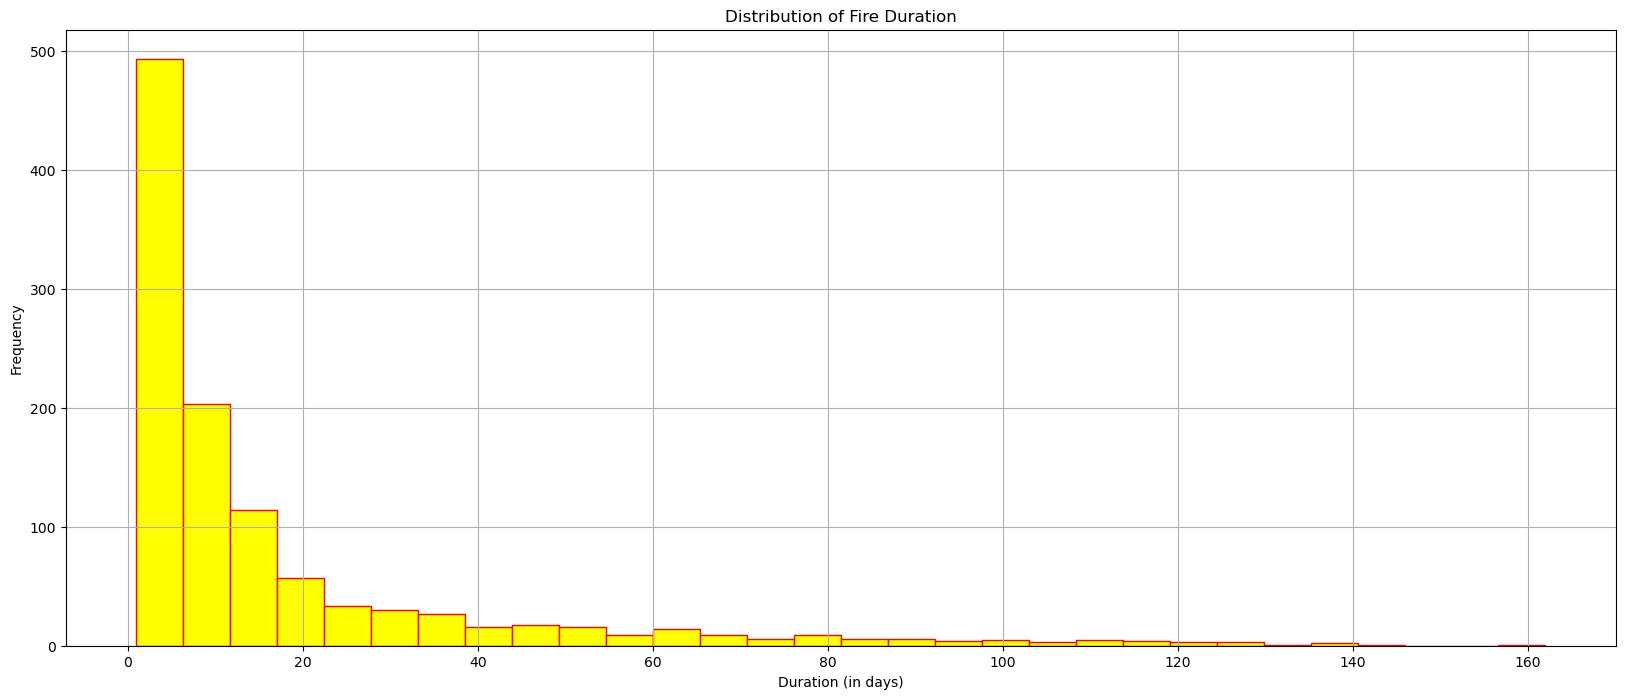

In [98]:
# Check data distribution based on fire durations to further validate our data 

# Plotting the distribution of the 'Duration' column
plt.figure(figsize=(20, 8))
plt.hist(fires_2008_2022_cleaned['Duration'], bins=30, color='yellow', edgecolor='red')
plt.title('Distribution of Fire Duration')
plt.xlabel('Duration (in days)')
plt.ylabel('Frequency')
# plt.xlim(0, 380)  # Set the x-axis limits from 0 to 380 for better visualization
plt.grid(True)
plt.show()

In [100]:
# The data is not normally distributed based on the shape of the histogram above.
# The histogtam also confirms no negative or zero fire durations

# To validate our data based on duration, IQR Method is used (more suitable when data distribution has a lot of variation).

# Calculate the first (Q1) and third (Q3) quartiles
Q1 = fires_2008_2022_cleaned['Duration'].quantile(0.25)
Q3 = fires_2008_2022_cleaned['Duration'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find and display fires with durations above the upper bound
outliers = fires_2008_2022_cleaned[fires_2008_2022_cleaned['Duration'] > upper_bound]

# Sort the outliers by 'Duration' in descending order
outliers_sorted = outliers.sort_values(by='Duration', ascending=False)

# Display only the top 10 outliers
print("Top 10 Fires with Suspiciously Long Durations (Outliers):")
print(outliers_sorted.head(10))


Top 10 Fires with Suspiciously Long Durations (Outliers):
         County    Fire Name      Start  Contained    Acres  Deaths_FF  \
645    MARIPOSA      CASCADE 2012-06-18 2012-11-26    1,705          0   
1109     TULARE  SQF COMPLEX 2020-08-19 2021-01-07  175,019          0   
1101     TULARE  RATTLESNAKE 2020-08-16 2020-12-31    8,419          0   
1106   MONTEREY        DOLAN 2020-08-18 2020-12-31  124,924          0   
1110     TULARE      MORAINE 2020-08-21 2020-12-31    1,316          0   
682   RIVERSIDE     HATHAWAY 2013-06-09 2013-10-15    3,870          0   
752    MARIPOSA        LAKES 2016-06-26 2016-10-31    1,001          0   
7        SONOMA         Pine 2008-06-10 2008-10-14      989          0   
553      TULARE         LION 2011-07-08 2011-11-08   20,500          0   
369      FRESNO        ROUGH 2015-07-31 2015-12-01  151,623          0   

      Deaths_Civil  Duration  Strux_Destr  Strux_Dmgd  
645              0       162            0           0  
1109           

In [87]:
# Correct the dates of long fires that do not match Google/ChatGPT reserch
fires_2008_2022_cleaned.loc[146, 'Contained'] = fires_2008_2022_cleaned.loc[146, 'Contained'].replace(year=2008)
fires_2008_2022_cleaned.at[645, 'Start'] = '2012-06-18'
fires_2008_2022_cleaned.at[798, 'Start'] = '2017-06-24'
fires_2008_2022_cleaned.at[798, 'Contained'] = '2017-06-26'
fires_2008_2022_cleaned.loc[860, 'Contained'] = fires_2008_2022_cleaned.loc[860, 'Contained'].replace(year=2019)
fires_2008_2022_cleaned.at[958, 'Contained'] = fires_2008_2022_cleaned.loc[956, 'Contained'].replace(year=2020)
fires_2008_2022_cleaned.at[1119, 'Contained'] = '2020-09-06'
fires_2008_2022_cleaned.at[1119, 'Contained'] = '2020-11-07'

# Ensure that the changes are in datetime format
fires_2008_2022_cleaned['Start'] = pd.to_datetime(fires_2008_2022_cleaned['Start'], errors='coerce')
fires_2008_2022_cleaned['Contained'] = pd.to_datetime(fires_2008_2022_cleaned['Contained'], errors='coerce')


# Verify the updated record
print("Corrected records:")
print(fires_2008_2022_cleaned.loc[[146, 645, 798, 860, 958, 1119]])

Corrected records:
        County  Fire Name      Start  Contained   Acres  Deaths_FF  \
146   MONTEREY      CHALK 2008-09-25 2008-10-29  16,269          0   
645   MARIPOSA    CASCADE 2012-06-18 2012-11-26   1,705          0   
798     TEHAMA       DALE 2017-06-24 2017-06-26     856          0   
860     COLUSA       SAND 2019-06-08 2019-06-15   2,220          0   
958     TULARE  SUCCESS 2 2020-06-18 2020-06-19     800          0   
1119  SISKIYOU      DEVIL 2020-09-09 2020-11-07   8,857          0   

      Deaths_Civil  Duration  Strux_Destr  Strux_Dmgd  
146              0    7340.0          NaN         NaN  
645              0     164.0          0.0         0.0  
798              0     366.0          0.0         0.0  
860              0     374.0          4.0         0.0  
958              0     369.0          0.0         0.0  
1119             0   11025.0          0.0         0.0  


In [88]:
# 'TRANSFORM': Convert 'Strux_Destr', 'Strux_Dmgd' columns to integers and replace NaN values with zero
fires_2008_2022_cleaned['Strux_Destr'] = pd.to_numeric(fires_2008_2022_cleaned['Strux_Destr'], errors='coerce').fillna(0).astype(int)
fires_2008_2022_cleaned['Strux_Dmgd'] = pd.to_numeric(fires_2008_2022_cleaned['Strux_Dmgd'], errors='coerce').fillna(0).astype(int)
print(fires_2008_2022_cleaned.loc[146])

County                     MONTEREY
Fire Name                     CHALK
Start           2008-09-25 00:00:00
Contained       2008-10-29 00:00:00
Acres                        16,269
Deaths_FF                         0
Deaths_Civil                      0
Duration                     7340.0
Strux_Destr                       0
Strux_Dmgd                        0
Name: 146, dtype: object


In [89]:
# Convert 'Start' and 'Contained' columns to datetime to correct the duration after changing fire dates in the code above
fires_2008_2022_cleaned['Start'] = pd.to_datetime(fires_2008_2022_cleaned['Start'])
fires_2008_2022_cleaned['Contained'] = pd.to_datetime(fires_2008_2022_cleaned['Contained'])

# Recalculate the 'Duration' for the entire DataFrame
# Add 1 day to account for the inclusive nature of start and contained dates
fires_2008_2022_cleaned['Duration'] = (fires_2008_2022_cleaned['Contained'] - fires_2008_2022_cleaned['Start']).dt.days + 1

# Check the dtype to verify the conversion
print(fires_2008_2022_cleaned['Duration'].dtype)

# Print the updated DataFrame to verify the recalculated 'Duration'
print("Updated DataFrame with recalculated Duration:")
print(fires_2008_2022_cleaned.head())

int64
Updated DataFrame with recalculated Duration:
             County              Fire Name      Start  Contained  Acres  \
100            LAKE  CONTROL BURN, GEYSERS 2008-02-13 2008-02-13    400   
0    SAN BERNARDINO                  Bluff 2008-03-16 2008-03-20    680   
101        MARIPOSA              WAWONA NW 2008-04-09 2008-04-19  1,130   
102     LOS ANGELES            SANTA ANITA 2008-04-26 2008-05-02    584   
103       RIVERSIDE                 APACHE 2008-04-29 2008-05-04    769   

     Deaths_FF  Deaths_Civil  Duration  Strux_Destr  Strux_Dmgd  
100          0             0         1            0           0  
0            0             0         5            0           0  
101          0             0        11            0           0  
102          0             0         7            0           0  
103          0             0         6            0           0  


In [90]:
# Check if any county are misspelled 
# List of valid county names
valid_counties = [
    'ALAMEDA', 'ALPINE', 'AMADOR', 'BUTTE', 'CALAVERAS', 'COLUSA', 'CONTRA COSTA', 
    'DEL NORTE', 'EL DORADO', 'FRESNO', 'GLENN', 'HUMBOLDT', 'IMPERIAL', 'INYO', 
    'KERN', 'KINGS', 'LAKE', 'LASSEN', 'LOS ANGELES', 'MADERA', 'MARIN', 'MARIPOSA', 
    'MENDOCINO', 'MERCED', 'MODOC', 'MONO', 'MONTEREY', 'NAPA', 'NEVADA', 'ORANGE', 
    'PLACER', 'PLUMAS', 'RIVERSIDE', 'SACRAMENTO', 'SAN BENITO', 'SAN BERNARDINO', 
    'SAN DIEGO', 'SAN FRANCISCO', 'SAN JOAQUIN', 'SAN LUIS OBISPO', 'SAN MATEO', 
    'SANTA BARBARA', 'SANTA CLARA', 'SANTA CRUZ', 'SHASTA', 'SIERRA', 'SISKIYOU', 
    'SOLANO', 'SONOMA', 'STANISLAUS', 'SUTTER', 'TEHAMA', 'TRINITY', 'TULARE', 
    'TUOLUMNE', 'VENTURA', 'YOLO', 'YUBA', 'JACKSON (OR)', 'WASHOE (NV)'
]

# Find counties that are not in the valid counties list
invalid_counties = fires_2008_2022_cleaned[~fires_2008_2022_cleaned['County'].isin(valid_counties)]

# Display the rows with invalid counties
print("Counties that do not match the valid list:")
print(invalid_counties[['County']])
# Saving incorrect list of misspelled counties for review
# invalid_counties.to_csv('Outputs/invalid_counties.csv', index = False) - commented to have only necesary files in "Outputs' folder"

Counties that do not match the valid list:
                                      County
1                               TEHAMA-GLENN
2                               FRESNO-KINGS
3                               FRESNO-KINGS
6                           SONOMA-LAKE-NAPA
9                           MARDERA-MARIPOSA
...                                      ...
1105                           PLUMAS, BUTTE
1113                          FRESNO, MADERA
1070                            NAPA, SONOMA
965   PLUMAS, BUTTE, LASSEN,\nSHASTA, TEHAMA
946                       PLACER,\nEL DORADO

[90 rows x 1 columns]


In [91]:
# 90 rows were not identified correctly (please see the output above)

# Define a function to clean up the 'County' column
def clean_county_name(county_name):
    # Remove text after '-', ',', and '/' and strip any extra whitespace
    return county_name.split('-')[0].split(',')[0].split('/')[0].split('\\')[0].split('\\n')[0].strip()

# Apply the cleaning function to the 'County' column
fires_2008_2022_cleaned['County'] = fires_2008_2022_cleaned['County'].apply(clean_county_name)

In [92]:
# Continue with your corrections dictionary for specific misspellings
corrections = {
    'TAHEMA': 'TEHAMA',
    'ELDORADO': 'EL DORADO',
    'TEHEMA': 'TEHAMA',
    'TOULUMNE': 'TUOLUMNE',
    'TUOLOMNE': 'TUOLUMNE',
    'WASHOE': 'WASHOE (NV)',
    'VANDENBURG AFB': 'SANTA BARBARA',
    'MARDERA': 'MADERA',
    'VENTURA/SANTA\nBARBARA': 'VENTURA',
    'COLUSA, GLENN,\nLAKE, MENDOCINO': 'COLUSA',
    'COLUSA, LAKE,\nMENDOCINO': 'COLUSA',
    'SANTA\nBARBARA': 'SANTA BARBARA',
    'SAN LUIS\nOBISPO': 'SAN LUIS OBISPO',
    'SAN\nBERNARDINO': 'SAN BERNARDINO',
    'VANDENBURG AFB': 'SANTA BARBARA'
}

# Apply the corrections to the 'County' column
fires_2008_2022_cleaned['County'] = fires_2008_2022_cleaned['County'].replace(corrections)


In [93]:
# Find counties that are not in the valid counties list
invalid_counties_test = fires_2008_2022_cleaned[~fires_2008_2022_cleaned['County'].isin(valid_counties)]

# Display the rows with invalid counties
print("Counties that do not match the valid list:")
print(invalid_counties_test[['County']])

Counties that do not match the valid list:
Empty DataFrame
Columns: [County]
Index: []


In [94]:
# Find and display repeated values in the 'Fire Name' column
repeated_fire_names = fires_2008_2022_cleaned[fires_2008_2022_cleaned.duplicated(subset='Fire Name', keep=False)]

# Display the rows with repeated 'Fire Name' values
print(repeated_fire_names[['County', 'Fire Name', 'Start', 'Contained', 'Acres', 'Deaths_FF', 'Deaths_Civil', 'Duration', 'Strux_Destr', 'Strux_Dmgd']])

# Create a list of fire names followed by the repeated fire names
repeated_fire_list = repeated_fire_names['Fire Name'].unique().tolist()

# Print the list of repeated fire names
print("List of repeated fire names:")
print(repeated_fire_names)
print(repeated_fire_list)

# Save the repeated fire names for further review
repeated_fire_names.to_csv('Outputs/repeated_fire_names.csv', index=False) 

          County             Fire Name      Start  Contained   Acres  \
101     MARIPOSA             WAWONA NW 2008-04-09 2008-04-19   1,130   
106       TULARE                CLOVER 2008-05-28 2008-07-20  15,300   
107         KERN             GRAPEVINE 2008-06-06 2008-06-08     507   
21     MENDOCINO  Jack Smith Lightning 2008-06-21 2008-07-13   3,000   
133       TEHAMA              ANTELOPE 2008-06-22 2008-06-26     600   
..           ...                   ...        ...        ...     ...   
939     MARIPOSA                   OAK 2022-07-22 2022-09-02  19,244   
941  LOS ANGELES                 ROUTE 2022-08-31 2022-09-06   5,208   
942     SISKIYOU                  MILL 2022-09-02 2022-09-14   3,939   
943     SISKIYOU              MOUNTAIN 2022-09-02 2022-10-30  13,440   
945       MADERA                  FORK 2022-09-07 2022-09-14     819   

     Deaths_FF  Deaths_Civil  Duration  Strux_Destr  Strux_Dmgd  
101          0             0        11            0           0  
106

In [95]:
## Based on the outputs and the number of fires, some fires that occcured in different counties at different times (117 fires) received repeated names, but
# To be on the safe side we remove duplicate fires based on 'Fire Name' and 'Start':
fires_2008_2022_cleaned = fires_2008_2022_cleaned.drop_duplicates(subset=['Fire Name', 'Start'])
# Save the cleaned data to the "Outputs" folder
fires_2008_2022_cleaned.to_csv('Outputs/fires_2008_2022_cleaned.csv', index=False)

# Print the cleaned data to check
print(fires_2008_2022_cleaned.tail(5))

        County Fire Name      Start  Contained   Acres  Deaths_FF  \
943   SISKIYOU  MOUNTAIN 2022-09-02 2022-10-30  13,440          0   
944  RIVERSIDE  FAIRVIEW 2022-09-05 2022-09-22  28,098          0   
946     PLACER  MOSQUITO 2022-09-06 2022-10-22  76,788          0   
945     MADERA      FORK 2022-09-07 2022-09-14     819          0   
947      MODOC    BARNES 2022-09-07 2022-09-28   5,843          0   

     Deaths_Civil  Duration  Strux_Destr  Strux_Dmgd  
943             0        59            4           0  
944             2        18           37           8  
946             0        47           78          14  
945             0         8           43           1  
947             0        22            2           0  
